In [1]:
import os
import cv2
import numpy as np

In [2]:
INPUT_DIR = '/home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit'
OUTPUT_DIR = '/home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed'

# this notebook merge the blender freestyle lines with the mesh

libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Freestyle image shape: (2048, 2048, 4)
Freestyle image type: uint8
Mesh image shape: (2048, 2048, 4)
Mesh image type: uint8


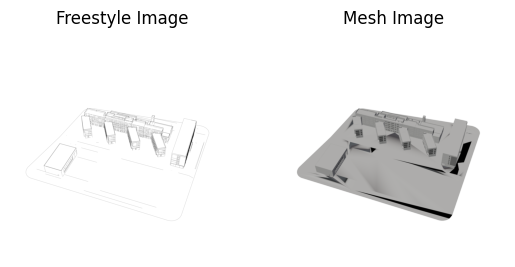

In [3]:
#first lets see what is the type and format of the files in the input directory
example_scene_freestyle = "/home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit/14/lod2/lod2_freestyle_az020_el45.png"
example_scene_mesh = "/home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit/14/lod2/lod2_mesh_az020_el45.png"

# load the freestyle image and the mesh image
freestyle_image = cv2.imread(example_scene_freestyle, cv2.IMREAD_UNCHANGED)
mesh_image = cv2.imread(example_scene_mesh, cv2.IMREAD_UNCHANGED)   

# check the shape and type of the images
print("Freestyle image shape:", freestyle_image.shape)
print("Freestyle image type:", freestyle_image.dtype)
print("Mesh image shape:", mesh_image.shape)
print("Mesh image type:", mesh_image.dtype) 

#show the freestyle image and the mesh image
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(freestyle_image)
plt.title('Freestyle Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(mesh_image)
plt.title('Mesh Image')
plt.axis('off')
plt.show()


Merged image shape: (2048, 2048, 4)


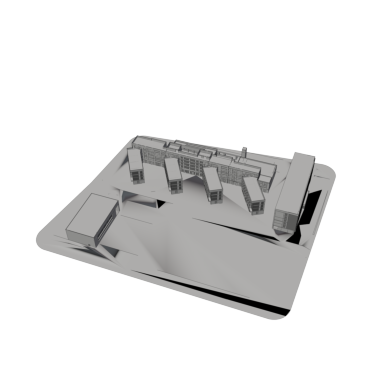

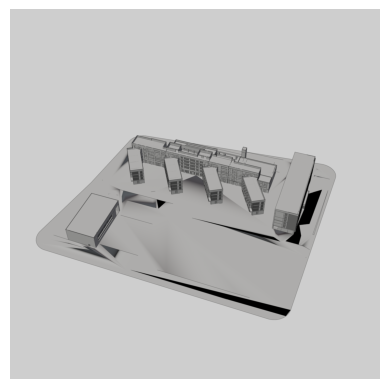

In [4]:
# Split channels
fs_rgb = freestyle_image[..., :3]
fs_alpha = freestyle_image[..., 3:] / 255.0  # normalize alpha to [0, 1]

mesh_rgb = mesh_image[..., :3]
mesh_alpha = mesh_image[..., 3:] / 255.0

# Composite RGB using alpha blending: fs over mesh
out_rgb = fs_rgb * fs_alpha + mesh_rgb * (1 - fs_alpha)

# Optional: Compose new alpha channel (keep mesh alpha if freestyle is transparent)
out_alpha = fs_alpha + mesh_alpha * (1 - fs_alpha)

# Merge RGB + alpha back
merged = np.dstack((out_rgb, out_alpha * 255)).astype(np.uint8)

# show the merged image with matplotlib
import matplotlib.pyplot as plt
print("Merged image shape:", merged.shape)
plt.imshow(merged)
plt.axis('off')
plt.show()

plt.imshow(cv2.cvtColor(merged, cv2.COLOR_RGBA2RGB))
plt.axis('off')
plt.show()



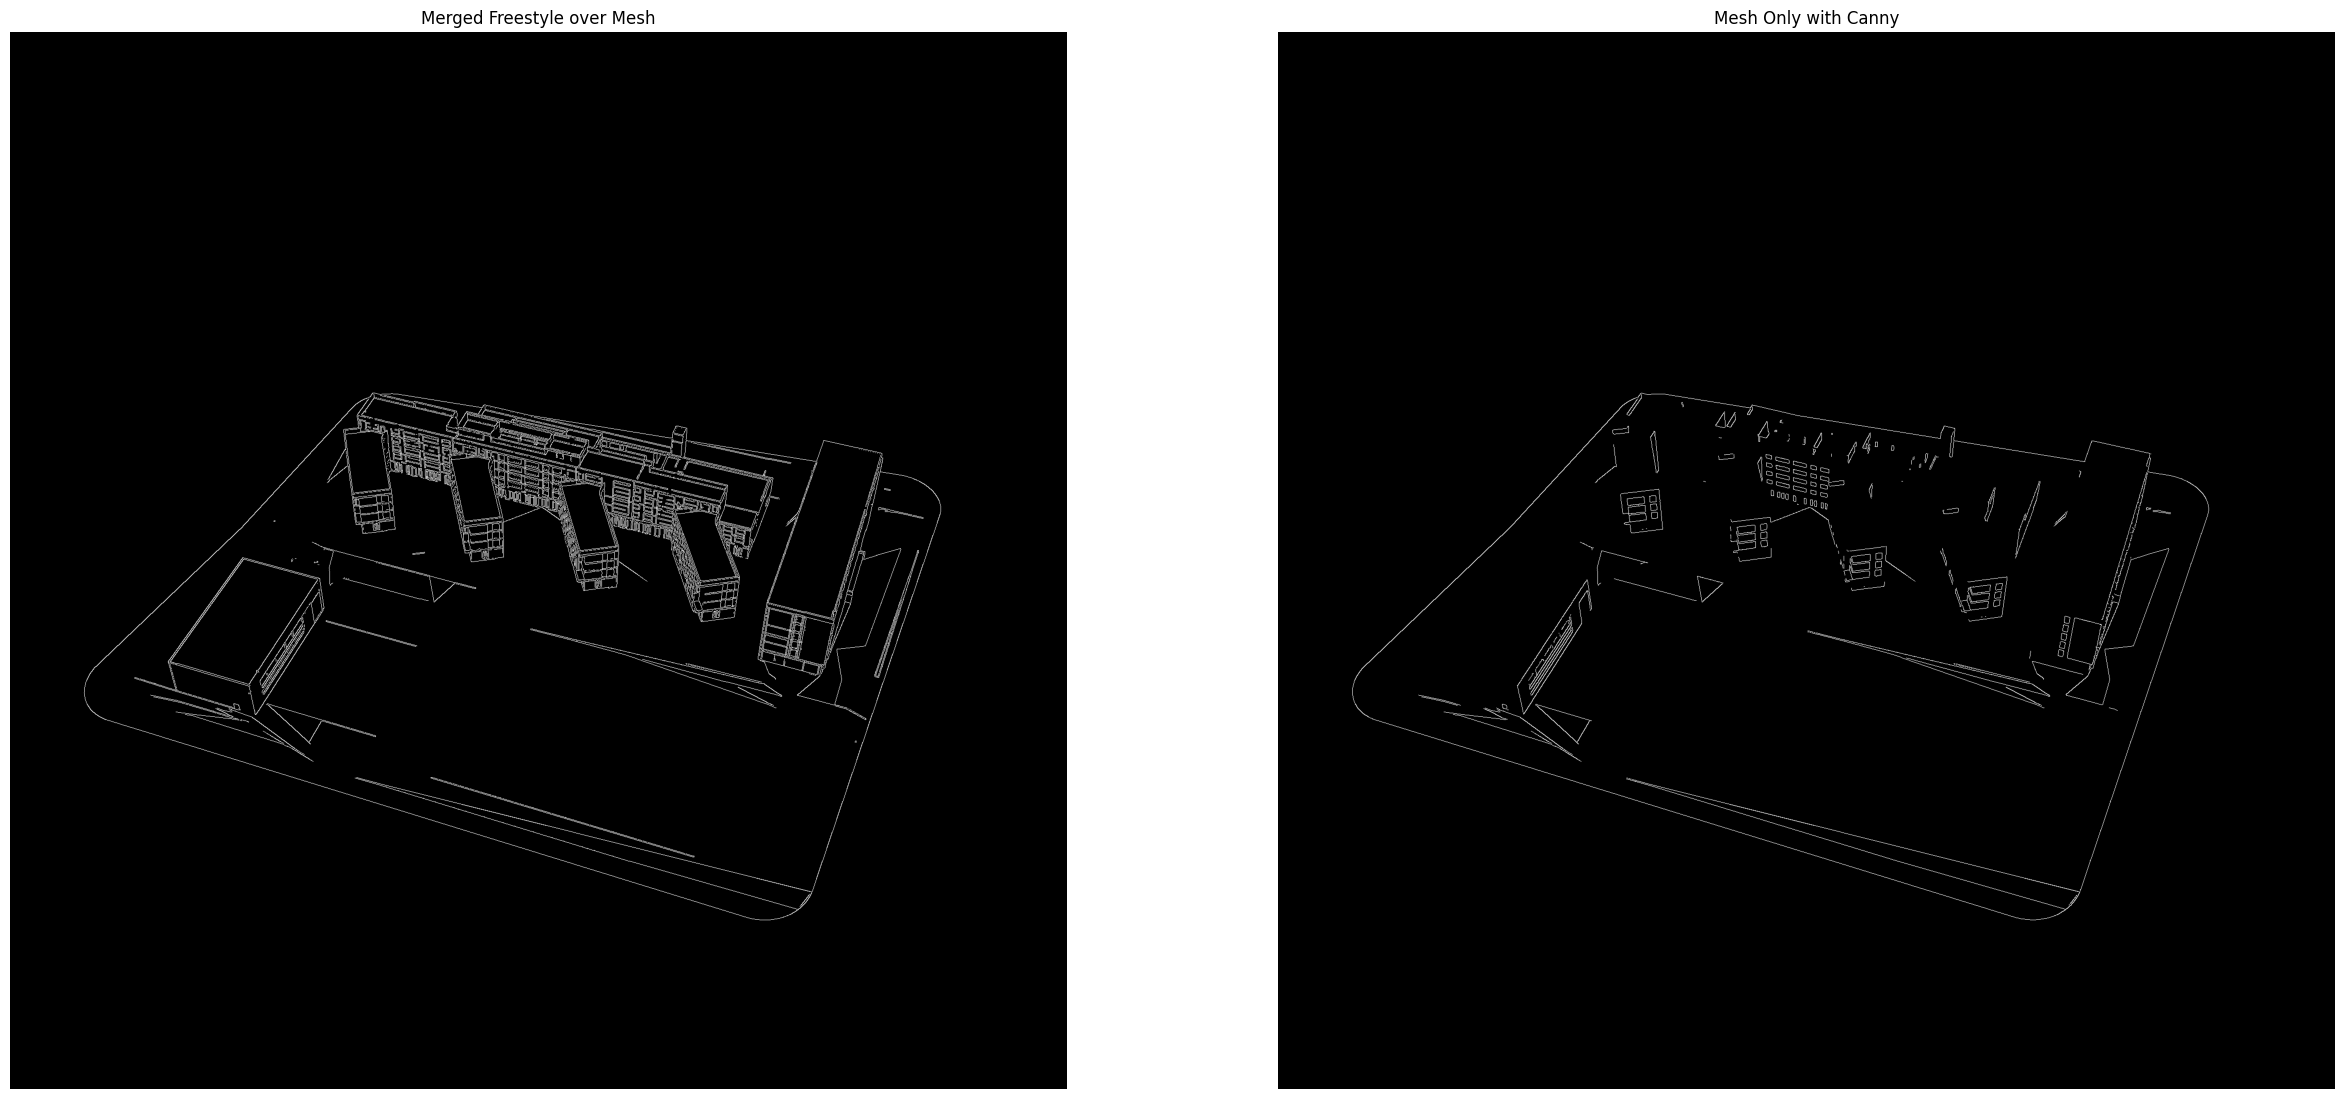

In [5]:
#apply canny edge detection to the merged image
low_threshold = 150
high_threshold = 200

image = cv2.Canny(merged, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)

# show the canny edge detected image
# versus the original mesh only image with canny edge detection
image_mesh = cv2.Canny(mesh_image, low_threshold, high_threshold)
image_mesh = image_mesh[:, :, None]
image_mesh = np.concatenate([image_mesh, image_mesh, image_mesh], axis=2)
plt.figure(figsize=(30, 15))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Merged Freestyle over Mesh')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image_mesh)
plt.title('Mesh Only with Canny')
plt.axis('off')
plt.show()



In [6]:
import os
import cv2
import numpy as np

# Define input/output directories
INPUT_DIR = '/home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit'
OUTPUT_DIR = '/home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed'
merged_images_output_dir = os.path.join(OUTPUT_DIR, 'merged_images')
canny_images_output_dir = os.path.join(OUTPUT_DIR, 'canny_images')

# Canny thresholds (set your values)
low_threshold = 100
high_threshold = 200

# Process loop
for root, dirs, files in os.walk(INPUT_DIR):
    for file in files:
        if file.endswith('.png') and 'freestyle' in file:
            freestyle_path = os.path.join(root, file)
            mesh_path = freestyle_path.replace('freestyle', 'mesh')

            # Load images
            freestyle_image = cv2.imread(freestyle_path, cv2.IMREAD_UNCHANGED)
            mesh_image = cv2.imread(mesh_path, cv2.IMREAD_UNCHANGED)

            if freestyle_image is None or mesh_image is None:
                print(f"Skipped {file}: missing image(s)")
                continue

            # Split alpha and RGB
            fs_rgb = freestyle_image[..., :3]
            fs_alpha = freestyle_image[..., 3:] / 255.0

            mesh_rgb = mesh_image[..., :3]
            mesh_alpha = mesh_image[..., 3:] / 255.0

            # Blend
            out_rgb = fs_rgb * fs_alpha + mesh_rgb * (1 - fs_alpha)
            out_alpha = fs_alpha + mesh_alpha * (1 - fs_alpha)
            merged = np.dstack((out_rgb, out_alpha * 255)).astype(np.uint8)
            merged = cv2.cvtColor(merged, cv2.COLOR_RGBA2RGB)

            # Extract scene number and lod from path
            relative_path = os.path.relpath(freestyle_path, INPUT_DIR)
            path_parts = relative_path.split(os.sep)
            if len(path_parts) < 3:
                print(f"Skipped {file}: unexpected directory structure")
                continue
            scene_num = path_parts[0]

            # Remove 'freestyle_' from filename for output
            output_filename = file.replace('freestyle_', '')

            # Create output subdirectories
            merged_output_subdir = os.path.join(merged_images_output_dir, scene_num)
            canny_output_subdir = os.path.join(canny_images_output_dir, scene_num)
            os.makedirs(merged_output_subdir, exist_ok=True)
            os.makedirs(canny_output_subdir, exist_ok=True)

            # Save merged image
            merged_output_path = os.path.join(merged_output_subdir, output_filename)
            cv2.imwrite(merged_output_path, merged)

            # Canny edge detection
            canny_image = cv2.Canny(merged, low_threshold, high_threshold)
            canny_image_colored = np.stack([canny_image] * 3, axis=-1)
            canny_output_path = os.path.join(canny_output_subdir, output_filename)
            cv2.imwrite(canny_output_path, canny_image_colored)

            print(f"Processed {file}: saved merged to {merged_output_path} and Canny to {canny_output_path}")


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az190_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az190_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az190_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az260_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az260_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az260_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az330_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az330_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az180_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az180_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az270_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az270_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az270_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az000_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az000_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az000_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az150_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az150_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az140_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az140_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az140_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az160_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az160_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az160_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az030_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az030_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az030_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az280_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az280_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az280_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az020_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az020_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az020_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az300_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az300_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az300_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az250_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az250_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az250_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az240_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az240_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az240_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az310_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az310_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az310_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az190_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az190_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az190_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az260_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az260_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az260_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az180_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az180_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az320_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az320_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az270_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az270_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az270_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az150_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az150_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az140_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az140_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az140_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az010_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az010_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az010_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az290_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az290_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az290_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az030_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az030_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az030_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az020_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az020_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az020_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az170_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az170_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az300_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az300_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az300_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az250_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az250_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az250_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az240_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az240_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az240_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az310_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az310_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az310_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az160_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az160_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az160_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az290_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az290_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az290_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az020_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az020_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az020_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az170_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az170_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az280_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az280_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az280_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az250_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az250_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az250_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az240_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az240_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az240_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az310_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az310_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az310_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az260_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az260_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az260_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az330_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az330_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az190_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az190_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az190_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az320_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az320_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az270_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az270_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az270_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az000_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az000_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az000_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az140_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az140_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az140_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az010_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az010_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az010_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az160_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az160_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az160_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az030_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az030_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az030_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az290_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az290_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az290_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az170_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az170_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az280_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az280_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az280_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az300_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az300_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az300_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az250_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az250_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az250_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az240_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az240_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az240_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az260_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az260_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az260_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az330_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az330_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az320_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az320_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az270_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az270_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az270_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az180_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az180_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az000_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az000_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az000_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az150_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az150_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az010_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az010_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az010_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az210_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az210_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az210_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az340_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az340_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az340_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az350_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az350_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az350_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az200_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az200_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az200_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az070_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az070_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az070_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az120_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az120_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az120_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az060_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az060_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az060_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az110_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az110_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az110_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az040_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az040_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az040_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az100_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az100_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az100_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az080_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az080_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az080_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az220_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az220_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az220_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az090_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az090_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az090_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az230_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az230_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az230_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az210_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az210_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az210_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az340_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az340_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az340_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az350_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az350_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az350_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az200_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az200_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az200_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az070_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az070_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az070_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az130_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az130_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az130_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az060_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az060_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az060_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az110_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az110_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az110_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az050_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az050_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az050_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az100_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az100_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az100_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az080_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az080_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az080_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az220_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az220_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az220_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az090_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az090_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az090_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az230_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az230_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az230_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az040_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az040_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az040_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az050_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az050_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az050_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az100_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az100_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az100_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az220_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az220_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az220_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az080_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az080_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az080_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az230_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az230_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az230_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az090_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az090_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az090_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az210_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az210_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az210_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az350_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az350_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az350_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az200_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az200_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az200_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az120_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az120_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az120_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az130_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az130_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az130_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az060_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az060_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az060_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az110_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az110_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az110_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az040_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az040_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az040_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az050_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az050_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az050_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az220_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az220_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az220_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az080_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az080_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az080_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az230_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az230_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az230_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az090_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az090_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az090_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az210_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az210_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az210_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az340_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az340_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az340_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az200_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az200_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az200_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az070_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az070_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az070_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az120_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az120_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az120_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az130_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az130_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az130_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az350_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az350_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az350_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az210_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az210_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az210_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az340_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az340_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az340_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az060_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az060_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az060_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az070_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az070_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az070_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az120_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az120_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az120_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az050_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az050_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az050_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az100_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az100_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az100_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az110_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az110_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az110_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az040_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az040_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az040_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az090_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az090_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az090_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az230_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az230_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az230_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az220_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az220_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az220_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az350_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az350_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az350_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az200_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az200_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az200_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az340_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az340_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az340_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az130_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az130_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az130_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az060_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az060_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az060_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az070_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az070_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az070_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az050_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az050_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az050_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az100_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az100_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az100_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az110_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az110_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az110_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az040_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az040_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az040_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az230_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az230_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az230_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az080_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az080_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az080_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az220_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az220_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az220_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az050_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az050_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az050_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az100_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az100_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az100_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az040_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az040_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az040_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az230_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az230_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az230_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az090_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az090_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az090_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az080_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az080_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az080_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az350_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az350_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az350_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az200_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az200_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az200_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az210_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az210_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az210_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az130_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az130_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az130_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az060_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az060_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az060_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az070_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az070_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az070_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az120_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az120_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az120_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az050_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az050_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az050_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az110_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az110_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az110_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az040_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az040_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az040_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az090_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az090_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az090_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az220_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az220_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az220_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az080_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az080_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az080_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az200_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az200_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az200_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az210_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az210_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az210_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az340_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az340_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az340_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az130_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az130_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az130_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az060_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az060_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az060_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az070_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az070_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az070_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az120_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az120_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az120_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az180_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az180_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az270_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az270_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az270_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az190_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az190_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az190_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az260_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az260_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az260_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az330_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az330_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az140_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az140_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az140_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az010_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az010_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az010_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az000_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az000_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az000_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az150_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az150_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az280_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az280_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az280_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az020_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az020_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az020_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az290_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az290_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az290_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az160_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az160_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az160_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az030_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az030_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az030_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az310_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az310_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az310_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az300_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az300_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az300_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az250_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az250_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az250_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az180_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az180_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az320_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az320_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az270_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az270_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az270_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az190_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az190_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az190_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az260_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az260_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az260_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az140_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az140_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az140_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az010_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az010_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az010_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az000_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az000_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az000_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az150_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az150_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az280_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az280_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az280_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az020_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az020_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az020_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az170_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az170_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az290_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az290_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az290_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az030_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az030_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az030_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az240_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az240_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az240_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az310_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az310_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az310_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az300_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az300_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az300_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az020_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az020_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az020_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az170_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az170_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az280_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az280_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az280_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az160_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az160_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az160_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az030_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az030_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az030_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az290_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az290_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az290_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az240_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az240_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az240_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az310_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az310_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az310_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az250_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az250_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az250_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az320_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az320_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az270_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az270_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az270_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az330_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az330_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az190_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az190_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az190_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az140_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az140_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az140_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az010_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az010_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az010_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az000_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az000_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az000_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az020_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az020_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az020_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az170_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az170_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az280_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az280_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az280_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az160_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az160_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az160_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az030_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az030_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az030_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az290_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az290_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az290_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az240_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az240_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az240_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az300_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az300_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az300_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az250_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az250_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az250_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az320_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az320_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az180_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az180_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az260_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az260_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az260_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az330_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az330_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az010_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az010_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az010_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az000_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az000_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az000_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az150_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az150_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az070_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az070_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az070_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az120_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az120_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az120_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az130_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az130_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az130_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az210_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az210_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az210_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az340_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az340_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az340_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az200_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az200_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az200_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az080_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az080_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az080_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az220_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az220_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az220_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az090_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az090_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az090_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az110_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az110_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az110_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az040_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az040_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az040_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az050_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az050_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az050_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az100_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az100_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az100_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az120_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az120_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az120_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az130_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az130_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az130_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az060_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az060_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az060_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az210_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az210_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az210_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az350_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az350_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az350_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az200_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az200_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az200_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az080_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az080_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az080_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az090_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az090_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az090_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az230_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az230_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az230_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az110_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az110_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az110_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az040_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az040_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az040_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az050_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az050_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az050_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az100_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az100_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az100_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az220_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az220_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az220_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az080_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az080_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az080_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az230_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az230_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az230_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az110_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az110_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az110_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az050_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az050_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az050_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az100_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az100_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az100_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az070_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az070_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az070_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az120_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az120_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az120_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az130_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az130_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az130_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az060_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az060_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az060_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az340_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az340_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az340_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az350_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az350_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az350_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az200_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az200_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az200_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az220_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az220_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az220_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az230_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az230_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az230_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az090_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az090_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az090_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az110_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az110_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az110_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az040_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az040_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az040_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az100_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az100_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az100_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az070_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az070_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az070_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az120_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az120_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az120_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az130_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az130_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az130_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az060_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az060_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az060_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az210_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az210_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az210_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az340_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az340_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az340_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az350_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az350_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az350_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az000_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az000_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az000_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az150_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az150_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az140_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az140_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az140_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az010_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az010_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az010_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az260_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az260_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az260_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az330_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az330_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az180_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az180_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az320_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az320_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az300_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az300_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az300_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az250_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az250_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az250_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az240_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az240_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az240_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az290_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az290_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az290_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az160_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az160_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az160_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az030_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az030_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az030_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az280_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az280_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az280_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az170_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az170_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az000_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az000_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az000_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az150_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az150_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az140_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az140_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az140_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az010_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az010_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az010_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az190_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az190_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az190_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az330_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az330_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az320_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az320_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az270_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az270_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az270_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az250_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az250_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az250_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az240_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az240_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az240_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az310_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az310_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az310_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az290_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az290_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az290_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az160_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az160_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az160_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az280_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az280_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az280_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az020_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az020_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az020_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az170_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az170_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az300_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az300_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az300_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az240_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az240_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az240_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az310_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az310_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az310_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az160_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az160_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az160_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az030_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az030_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az030_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az290_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az290_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az290_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az020_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az020_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az020_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az170_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az170_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az150_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az150_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az140_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az140_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az140_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az010_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az010_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az010_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az260_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az260_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az260_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az190_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az190_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az190_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az320_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az320_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az270_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az270_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az270_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az180_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az180_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az300_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az300_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az300_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az250_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az250_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az250_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az310_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az310_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az310_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az160_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az160_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az160_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az030_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az030_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az030_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az020_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az020_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az020_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az170_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az170_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az280_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az280_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az280_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az000_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az000_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az000_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az150_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az150_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az140_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az140_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az140_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az260_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az260_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az260_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az330_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az330_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az190_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az190_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az190_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az270_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az270_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az270_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az180_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az180_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az010_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az010_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az010_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az000_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az000_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az000_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az150_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az150_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az180_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az180_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az320_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az320_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az190_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az190_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az190_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az260_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az260_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az260_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az330_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az330_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az240_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az240_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az240_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az310_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az310_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az310_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az300_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az300_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az300_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az250_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az250_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az250_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az280_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az280_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az280_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az170_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az170_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az290_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az290_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az290_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az160_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az160_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az160_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az030_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az030_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az030_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az140_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az140_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az140_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az010_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az010_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az010_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az000_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az000_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az000_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az180_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az180_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az320_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az320_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az270_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az270_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az270_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az190_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az190_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az190_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az330_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az330_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az240_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az240_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az240_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az310_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az310_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az310_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az300_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az300_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az300_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az250_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az250_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az250_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az280_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az280_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az280_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az020_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az020_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az020_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az170_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az170_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az290_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az290_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az290_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az160_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az160_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az160_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az240_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az240_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az240_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az310_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az310_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az310_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az300_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az300_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az300_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az020_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az020_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az020_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az170_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az170_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az030_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az030_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az030_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az290_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az290_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az290_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az140_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az140_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az140_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az010_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az010_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az010_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az150_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az150_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az320_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az320_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az270_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az270_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az270_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az180_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az180_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az260_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az260_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az260_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az330_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az330_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az190_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az190_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az190_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az310_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az310_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az310_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az300_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az300_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az300_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az250_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az250_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az250_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az020_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az020_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az020_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az280_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az280_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az280_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az160_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az160_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az160_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az030_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az030_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az030_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az140_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az140_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az140_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az000_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az000_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az000_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az150_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az150_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az320_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az320_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az270_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az270_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az270_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az180_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az180_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az260_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az260_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az260_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az330_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az330_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az190_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az190_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az190_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az130_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az130_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az130_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az070_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az070_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az070_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az120_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az120_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az120_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az350_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az350_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az350_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az200_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az200_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az200_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az210_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az210_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az210_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az340_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az340_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az340_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az090_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az090_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az090_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az080_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az080_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az080_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az220_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az220_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az220_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az050_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az050_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az050_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az110_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az110_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az110_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az040_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az040_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az040_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az130_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az130_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az130_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az060_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az060_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az060_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az120_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az120_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az120_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az350_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az350_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az350_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az200_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az200_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az200_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az210_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az210_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az210_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az340_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az340_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az340_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az090_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az090_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az090_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az230_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az230_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az230_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az080_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az080_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az080_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az050_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az050_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az050_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az100_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az100_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az100_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az040_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az040_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az040_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az230_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az230_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az230_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az220_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az220_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az220_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az080_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az080_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az080_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az050_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az050_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az050_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az100_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az100_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az100_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az110_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az110_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az110_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az130_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az130_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az130_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az060_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az060_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az060_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az070_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az070_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az070_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az350_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az350_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az350_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az200_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az200_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az200_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az340_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az340_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az340_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az230_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az230_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az230_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az090_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az090_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az090_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az220_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az220_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az220_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az100_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az100_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az100_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az110_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az110_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az110_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az040_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az040_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az040_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az060_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az060_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az060_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az070_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az070_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az070_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az120_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az120_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az120_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az350_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az350_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az350_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az210_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az210_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az210_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az340_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod2_az340_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod2_az340_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az150_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az150_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az000_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az000_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az010_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az010_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az140_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az140_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az330_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az330_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az260_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az260_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az180_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az180_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az320_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az320_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az250_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az250_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az300_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az300_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az240_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az240_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az290_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az290_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az030_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az030_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az160_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az160_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az280_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az280_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az170_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az170_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az150_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az150_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az000_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az000_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az010_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az010_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az140_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az140_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az190_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az190_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az330_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az330_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az270_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az270_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az320_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az320_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az250_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az250_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az310_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az310_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az240_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az240_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az290_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az290_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az160_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az160_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az280_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az280_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az170_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az170_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az020_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az020_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az300_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az300_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az310_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az310_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az240_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az240_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az030_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az030_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az160_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az160_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az290_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az290_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az170_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az170_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az020_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az020_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az150_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az150_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az010_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az010_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az140_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az140_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az260_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az260_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az190_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az190_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az270_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az270_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az320_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az320_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az180_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az180_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az250_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az250_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az300_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az300_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az310_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az310_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az030_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az030_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az160_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az160_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az170_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az170_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az020_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az020_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az280_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az280_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az150_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az150_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az000_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az000_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az140_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az140_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az330_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az330_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az260_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az260_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az190_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az190_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az270_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az270_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az180_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az180_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az120_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az120_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az070_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az070_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az130_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az130_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az340_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az340_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az210_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az210_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az200_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az200_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az080_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az080_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az220_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az220_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az090_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az090_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az040_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az040_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az110_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az110_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az100_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az100_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az050_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az050_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az120_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az120_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az060_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az060_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az130_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az130_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az210_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az210_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az200_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az200_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az350_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az350_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az080_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az080_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az090_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az090_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az230_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az230_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az040_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az040_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az110_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az110_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az100_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az100_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az050_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az050_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az220_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az220_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az080_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az080_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az230_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az230_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az110_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az110_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az100_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az100_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az050_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az050_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az120_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az120_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az070_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az070_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az060_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az060_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az130_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az130_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az340_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az340_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az200_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az200_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az350_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az350_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az220_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az220_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az230_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az230_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az090_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az090_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az040_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az040_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az110_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az110_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az100_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az100_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az120_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az120_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az070_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az070_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az060_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az060_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az130_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az130_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az340_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az340_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az210_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az210_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az350_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az350_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az130_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az130_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az120_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az120_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az070_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az070_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az200_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az200_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az350_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az350_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az340_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az340_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az210_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az210_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az090_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az090_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az080_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az080_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az220_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az220_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az050_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az050_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az040_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az040_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az110_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az110_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az060_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az060_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az130_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az130_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az120_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az120_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az200_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az200_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az350_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az350_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az340_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az340_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az210_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az210_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az090_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az090_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az230_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az230_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az080_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az080_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az100_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az100_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az050_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az050_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az040_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az040_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az230_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az230_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az220_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az220_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az080_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az080_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az100_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az100_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az050_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az050_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az110_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az110_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az060_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az060_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az130_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az130_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az070_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az070_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az200_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az200_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az350_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az350_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az340_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az340_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az230_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az230_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az090_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az090_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az220_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az220_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az100_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az100_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az040_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az040_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az110_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az110_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az060_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az060_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az120_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az120_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az070_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az070_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az350_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az350_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az340_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az340_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az210_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az210_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az010_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az010_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az150_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az150_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az000_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az000_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az180_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az180_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az320_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az320_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az190_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az190_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az330_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az330_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az260_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az260_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az310_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az310_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az240_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az240_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az250_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az250_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az300_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az300_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az280_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az280_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az170_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az170_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az290_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az290_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az030_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az030_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az160_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az160_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az010_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az010_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az140_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az140_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az000_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az000_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az180_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az180_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az270_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az270_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az320_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az320_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az190_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az190_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az330_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az330_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az310_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az310_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az240_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az240_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az250_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az250_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az300_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az300_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az280_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az280_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az170_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az170_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az020_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az020_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az290_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az290_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az160_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az160_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az310_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az310_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az240_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az240_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az300_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az300_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az170_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az170_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az020_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az020_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az030_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az030_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az290_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az290_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az010_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az010_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az140_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az140_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az150_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az150_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az270_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az270_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az320_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az320_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az180_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az180_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az330_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az330_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az260_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az260_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az190_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az190_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az310_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az310_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az250_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az250_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az300_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az300_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az020_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az020_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az280_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az280_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az030_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az030_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az160_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az160_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az140_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az140_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az150_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az150_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az000_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az000_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az270_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az270_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az320_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az320_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az180_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az180_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az330_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az330_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az260_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az260_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az190_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az190_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az340_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az340_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az210_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az210_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az200_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az200_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az350_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az350_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az120_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az120_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az070_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az070_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az060_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az060_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az040_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az040_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az110_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az110_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az100_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az100_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az080_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az080_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az220_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az220_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az090_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az090_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az230_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az230_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az340_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az340_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az210_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az210_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az200_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az200_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az350_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az350_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az070_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az070_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az060_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az060_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az130_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az130_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az110_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az110_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az100_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az100_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az050_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az050_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az080_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az080_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az220_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az220_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az090_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az090_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az230_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az230_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az040_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az040_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az100_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az100_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az050_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az050_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az220_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az220_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az080_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az080_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az230_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az230_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az090_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az090_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az210_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az210_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az200_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az200_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az350_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az350_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az120_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az120_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az060_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az060_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az130_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az130_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az040_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az040_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az110_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az110_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az050_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az050_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az220_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az220_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az080_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az080_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az230_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az230_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az090_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az090_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az340_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az340_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az210_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az210_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az200_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az200_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az120_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az120_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az070_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az070_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az130_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az130_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az190_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az190_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az330_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az330_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az260_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az260_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az180_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az180_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az270_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az270_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az150_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az150_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az000_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az000_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az140_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az140_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az030_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az030_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az160_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az160_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az280_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az280_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az020_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az020_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az250_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az250_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az300_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az300_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az310_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az310_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az240_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az240_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az190_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az190_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az260_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az260_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az180_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az180_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az270_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az270_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az320_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az320_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az150_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az150_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az010_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az010_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az140_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az140_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az290_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az290_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az030_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az030_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az170_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az170_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az020_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az020_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az250_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az250_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az300_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az300_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az310_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az310_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az240_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az240_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az160_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az160_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az290_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az290_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az170_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az170_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az020_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az020_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az280_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az280_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az250_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az250_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az310_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az310_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az240_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az240_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az330_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az330_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az260_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az260_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az190_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az190_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az270_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az270_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az320_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az320_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az000_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az000_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az010_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az010_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az140_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az140_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az030_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az030_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az160_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az160_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az290_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az290_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az170_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az170_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az280_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az280_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az250_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az250_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az300_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az300_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az240_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az240_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az330_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az330_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az260_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az260_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az270_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az270_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az320_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az320_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az180_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az180_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az150_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az150_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az000_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az000_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az010_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az010_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az180_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az180_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az270_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az270_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az190_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az190_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az330_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az330_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az260_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az260_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az010_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az010_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az140_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az140_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az150_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az150_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az000_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az000_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az280_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az280_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az020_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az020_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az290_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az290_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az030_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az030_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az160_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az160_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az310_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az310_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az250_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az250_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az300_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az300_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az180_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az180_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az270_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az270_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az320_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az320_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az190_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az190_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az260_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az260_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az010_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az010_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az140_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az140_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az150_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az150_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az000_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az000_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az280_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az280_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az170_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az170_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az020_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az020_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az290_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az290_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az030_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az030_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az310_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az310_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az240_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az240_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az300_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az300_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az170_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az170_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az020_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az020_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az280_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az280_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az030_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az030_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az160_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az160_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az290_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az290_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az310_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az310_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az240_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az240_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az250_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az250_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az270_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az270_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az320_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az320_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az330_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az330_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az190_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az190_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az010_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az010_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az140_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az140_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az000_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az000_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az170_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az170_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az020_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az020_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az280_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az280_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az030_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az030_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az160_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az160_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az290_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az290_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az240_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az240_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az250_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az250_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az300_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az300_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az320_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az320_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az180_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az180_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az330_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az330_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az260_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az260_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az010_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az010_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az150_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az150_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az000_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az000_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az350_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az350_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az340_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az340_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az210_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az210_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az060_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az060_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az120_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az120_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az070_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az070_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az100_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az100_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az050_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az050_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az040_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az040_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az110_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az110_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az090_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az090_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az230_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az230_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az220_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az220_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az200_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az200_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az350_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az350_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az340_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az340_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az060_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az060_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az130_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az130_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az070_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az070_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az100_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az100_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az050_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az050_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az040_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az040_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az110_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az110_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az230_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az230_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az080_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az080_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az220_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az220_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az100_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az100_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az050_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az050_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az040_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az040_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az230_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az230_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az090_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az090_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az080_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az080_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az200_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az200_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az350_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az350_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az210_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az210_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az060_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az060_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az130_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az130_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az120_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az120_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az070_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az070_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az050_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az050_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az040_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az040_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az110_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az110_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az090_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az090_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az220_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az220_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az080_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az080_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az200_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az200_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az340_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az340_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az210_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az210_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az060_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az060_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az130_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az130_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az120_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az120_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/14/lod1_az070_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/14/lod1_az070_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az140_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az140_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az150_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az150_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az000_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az000_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az180_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az180_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az270_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az270_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az320_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az320_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az190_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az190_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az330_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az330_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az260_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az260_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az310_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az310_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az250_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az250_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az300_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az300_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az280_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az280_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az020_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az020_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az030_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az030_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az160_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az160_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az010_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az010_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az140_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az140_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az150_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az150_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az180_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az180_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az270_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az270_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az320_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az320_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az190_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az190_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az330_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az330_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az260_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az260_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az310_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az310_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az240_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az240_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az300_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az300_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az170_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az170_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az020_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az020_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az290_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az290_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az030_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az030_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az310_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az310_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az240_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az240_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az250_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az250_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az300_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az300_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az170_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az170_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az020_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az020_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az280_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az280_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az160_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az160_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az290_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az290_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az010_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az010_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az140_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az140_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az000_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az000_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az270_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az270_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az320_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az320_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az180_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az180_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az330_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az330_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az190_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az190_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az310_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az310_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az240_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az240_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az250_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az250_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az300_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az300_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az170_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az170_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az280_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az280_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az030_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az030_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az160_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az160_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az290_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az290_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az010_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az010_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az150_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az150_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az000_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az000_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az320_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az320_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az180_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az180_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az330_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az330_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az260_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az260_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az190_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az190_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az060_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az060_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az120_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az120_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az070_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az070_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az350_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az350_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az340_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az340_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az210_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az210_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az090_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az090_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az230_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az230_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az220_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az220_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az100_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az100_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az040_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az040_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az110_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az110_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az060_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az060_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az130_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az130_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az070_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az070_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az200_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az200_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az350_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az350_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az340_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az340_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az230_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az230_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az080_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az080_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az220_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az220_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az100_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az100_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az050_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az050_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az110_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az110_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az230_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az230_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az090_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az090_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az080_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az080_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az100_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az100_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az050_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az050_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az040_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az040_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az060_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az060_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az130_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az130_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az120_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az120_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az200_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az200_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az350_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az350_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az340_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az340_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az210_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az210_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az090_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az090_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az220_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az220_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az080_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az080_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az050_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az050_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az040_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az040_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az110_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az110_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az130_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az130_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az120_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az120_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az070_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az070_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az200_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az200_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az350_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az350_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az340_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az340_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az210_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az210_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az120_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az120_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az070_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az070_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az060_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az060_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az130_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az130_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az340_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az340_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az210_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az210_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az350_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az350_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az220_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az220_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az090_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az090_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az230_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az230_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az040_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az040_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az110_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az110_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az100_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az100_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az120_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az120_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az070_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az070_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az060_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az060_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az130_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az130_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az340_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az340_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az200_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az200_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az350_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az350_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az080_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az080_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az220_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az220_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az230_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az230_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az110_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az110_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az100_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az100_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az050_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az050_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az080_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az080_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az230_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az230_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az090_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az090_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az040_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az040_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az110_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az110_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az100_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az100_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az050_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az050_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az120_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az120_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az060_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az060_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az130_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az130_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az210_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az210_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az200_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az200_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az350_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az350_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az220_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az220_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az080_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az080_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az090_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az090_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az040_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az040_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az110_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az110_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az100_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az100_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az050_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az050_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az120_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az120_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az070_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az070_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az130_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az130_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az340_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az340_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az210_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az210_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az200_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az200_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az150_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az150_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az000_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az000_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az140_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az140_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az190_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az190_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az330_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az330_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az260_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az260_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az180_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az180_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az270_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az270_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az250_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az250_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az300_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az300_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az310_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az310_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az030_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az030_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az160_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az160_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az280_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az280_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az170_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az170_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az020_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az020_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az150_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az150_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az010_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az010_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az140_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az140_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az190_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az190_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az260_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az260_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az180_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az180_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az270_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az270_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az320_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az320_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az300_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az300_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az310_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az310_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az240_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az240_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az290_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az290_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az030_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az030_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az160_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az160_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az170_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az170_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az020_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az020_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az250_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az250_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az310_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az310_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az240_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az240_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az160_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az160_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az290_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az290_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az170_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az170_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az020_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az020_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az280_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az280_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az150_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az150_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az000_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az000_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az010_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az010_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az140_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az140_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az330_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az330_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az190_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az190_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az270_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az270_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az320_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az320_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az250_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az250_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az300_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az300_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az240_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az240_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az030_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az030_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az160_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az160_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az290_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az290_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az170_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az170_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az280_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az280_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az150_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az150_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az000_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az000_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az010_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az010_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az140_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az140_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az330_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az330_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az260_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az260_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az320_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az320_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az180_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az180_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az200_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az200_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az340_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az340_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az210_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az210_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az060_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az060_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az130_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az130_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az120_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az120_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az070_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az070_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az050_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az050_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az040_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az040_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az110_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az110_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az090_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az090_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az080_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az080_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az220_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az220_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az200_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az200_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az350_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az350_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az210_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az210_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az060_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az060_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az130_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az130_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az120_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az120_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az070_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az070_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az100_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az100_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az050_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az050_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az040_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az040_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az090_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az090_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az230_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az230_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az080_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az080_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az100_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az100_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az050_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az050_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az040_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az040_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az110_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az110_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az230_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az230_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az220_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az220_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az080_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az080_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az200_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az200_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az350_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az350_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az340_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az340_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az060_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az060_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az130_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az130_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az070_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az070_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az100_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az100_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az050_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az050_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az040_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az040_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az110_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az110_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az230_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az230_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az090_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az090_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az220_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az220_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az350_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az350_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az340_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az340_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az210_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az210_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az060_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az060_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az120_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az120_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az070_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az070_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az180_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az180_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az320_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az320_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az330_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az330_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az260_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az260_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az010_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az010_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az150_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az150_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az000_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az000_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az280_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az280_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az170_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az170_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az020_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az020_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az290_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az290_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az030_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az030_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az160_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az160_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az240_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az240_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az250_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az250_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az300_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az300_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az270_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az270_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az320_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az320_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az190_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az190_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az330_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az330_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az010_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az010_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az140_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az140_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az000_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az000_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az280_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az280_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az170_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az170_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az020_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az020_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az290_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az290_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az030_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az030_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az160_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az160_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az310_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az310_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az240_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az240_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az250_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az250_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az170_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az170_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az020_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az020_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az280_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az280_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az030_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az030_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az290_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az290_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az310_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az310_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az240_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az240_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az300_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az300_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az270_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az270_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az320_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az320_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az180_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az180_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az260_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az260_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az190_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az190_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az010_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az010_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az140_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az140_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az150_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az150_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az000_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az000_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az020_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az020_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az280_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az280_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az030_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az030_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az160_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az160_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az290_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az290_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az310_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az310_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az250_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az250_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az300_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az300_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az270_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az270_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az180_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az180_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az330_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az330_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az260_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az260_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az190_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az190_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az010_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az010_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az140_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az140_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az150_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az150_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az000_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az000_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az330_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az330_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az260_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az260_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az180_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az180_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az270_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az270_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az320_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az320_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az150_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az150_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az000_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az000_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az010_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az010_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az290_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az290_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az030_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az030_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az160_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az160_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az280_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az280_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az170_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az170_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az250_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az250_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az300_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az300_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az240_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az240_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az190_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az190_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az330_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az330_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az260_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az260_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az270_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az270_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az320_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az320_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az000_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az000_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az010_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az010_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az140_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az140_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az290_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az290_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az160_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az160_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az280_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az280_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az170_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az170_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az020_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az020_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az250_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az250_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az310_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az310_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az240_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az240_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az030_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az030_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az290_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az290_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az290_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az170_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az170_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az170_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az020_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az020_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az250_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az250_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az300_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az300_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az310_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az310_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az240_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az240_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az260_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az260_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az190_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az190_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az270_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az270_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az320_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az320_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az320_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az180_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az180_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az150_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az150_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az010_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az010_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az010_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az140_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az140_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az030_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az030_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az030_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az160_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az160_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az160_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az020_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az020_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az020_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az280_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az280_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az280_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az250_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az250_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az250_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az300_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az300_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az300_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az310_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az310_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az310_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az240_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az240_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az240_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az330_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az330_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az330_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az260_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az260_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az260_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az190_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az190_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az190_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az270_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az270_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az270_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az180_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az180_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az180_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az150_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az150_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az150_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az000_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az000_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az000_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az140_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az140_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az140_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az340_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az340_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az210_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az210_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az200_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az200_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az120_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az120_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az070_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az070_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az130_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az130_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az040_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az040_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az110_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az110_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az050_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az050_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az080_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az080_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az220_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az220_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az090_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az090_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az230_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az230_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az210_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az210_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az200_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az200_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az350_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az350_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az120_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az120_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az060_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az060_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az130_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az130_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az040_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az040_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az100_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az100_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az050_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az050_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az080_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az080_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az220_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az220_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az090_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az090_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az230_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az230_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az110_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az110_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az100_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az100_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az050_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az050_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az050_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az220_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az220_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az080_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az080_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az230_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az230_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az090_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az090_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az340_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az340_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az210_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az210_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az200_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az200_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az350_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az350_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az070_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az070_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az060_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az060_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az130_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az130_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az130_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az040_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az040_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az040_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az110_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az110_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az110_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az100_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az100_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az100_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az220_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az220_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az220_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az080_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az080_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az080_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az230_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az230_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az230_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az090_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az090_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az090_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az340_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az340_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az340_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az210_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az210_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az210_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az200_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az200_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az200_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az350_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az350_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az350_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az120_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az120_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az120_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az070_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az070_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az070_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod1_freestyle_az060_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod1_az060_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod1_az060_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az060_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az060_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az060_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az120_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az120_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az120_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az070_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az070_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az070_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az350_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az350_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az350_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az340_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az340_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az340_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az210_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az210_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az210_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az230_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az230_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az230_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az090_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az090_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az090_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az220_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az220_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az220_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az100_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az100_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az100_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az040_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az040_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az040_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az110_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az110_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az110_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az060_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az060_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az060_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az130_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az130_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az130_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az070_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az070_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az070_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az200_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az200_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az200_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az350_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az350_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az350_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az340_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az340_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az340_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az230_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az230_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az230_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az220_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az220_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az220_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az080_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az080_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az080_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az100_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az100_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az100_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az050_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az050_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az050_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az110_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az110_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az110_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az090_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az090_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az090_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az230_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az230_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az230_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az080_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az080_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az080_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az100_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az100_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az100_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az050_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az050_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az050_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az040_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az040_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az040_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az060_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az060_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az060_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az130_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az130_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az130_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az120_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az120_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az120_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az200_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az200_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az200_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az350_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az350_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az350_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az340_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az340_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az340_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az210_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az210_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az210_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az090_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az090_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az090_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az080_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az080_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az080_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az220_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az220_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az220_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az050_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az050_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az050_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az040_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az040_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az040_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az110_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az110_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az110_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az130_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az130_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az130_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az120_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az120_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az120_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az070_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az070_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az070_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az200_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az200_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az200_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az350_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az350_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az350_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az340_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az340_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az340_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az210_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az210_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az210_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az140_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az140_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az140_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az150_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az150_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az000_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az000_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az000_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az270_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az270_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az270_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az320_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az320_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az180_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az180_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az330_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az330_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az260_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az260_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az260_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az190_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az190_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az190_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az310_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az310_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az310_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az250_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az250_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az250_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az300_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az300_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az300_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az020_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az020_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az020_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az280_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az280_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az280_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az030_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az030_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az030_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az160_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az160_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az160_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az010_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az010_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az010_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az140_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az140_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az140_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az150_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az150_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az270_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az270_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az270_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az320_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az320_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az180_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az180_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az330_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az330_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az260_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az260_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az260_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az190_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az190_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az190_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az310_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az310_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az310_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az240_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az240_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az240_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az300_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az300_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az300_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az170_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az170_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az020_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az020_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az020_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az030_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az030_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az030_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az290_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az290_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az290_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az310_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az310_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az310_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az240_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az240_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az240_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az250_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az250_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az250_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az300_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az300_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az300_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az280_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az280_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az280_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az170_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az170_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az020_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az020_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az020_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az290_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az290_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az290_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az160_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az160_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az160_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az010_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az010_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az010_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az140_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az140_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az140_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az000_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az000_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az000_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az180_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az180_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az270_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az270_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az270_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az320_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az320_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az190_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az190_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az190_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az330_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az330_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az310_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az310_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az310_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az240_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az240_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az240_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az250_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az250_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az250_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az300_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az300_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az300_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az280_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az280_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az280_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az170_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az170_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az290_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az290_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az290_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az030_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az030_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az030_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az160_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az160_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az160_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az010_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az010_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az010_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az150_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az150_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az000_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az000_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az000_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az180_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az180_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az320_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az320_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az190_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az190_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az190_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az330_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az330_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az260_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az260_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az260_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az150_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az150_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az000_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az000_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az000_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az140_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az140_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az140_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az330_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az330_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az260_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az260_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az260_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az190_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az190_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az190_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az270_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az270_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az270_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az180_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az180_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az250_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az250_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az250_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az300_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az300_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az300_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az310_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az310_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az310_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az030_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az030_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az030_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az160_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az160_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az160_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az170_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az170_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az020_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az020_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az020_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az280_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az280_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az280_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az150_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az150_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az010_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az010_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az010_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az140_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az140_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az140_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az260_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az260_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az260_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az190_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az190_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az190_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az270_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az270_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az270_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az320_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az320_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az180_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az180_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az300_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az300_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az300_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az310_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az310_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az310_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az240_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az240_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az240_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az030_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az030_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az030_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az160_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az160_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az160_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az290_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az290_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az290_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az170_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az170_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az020_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az020_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az020_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az250_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az250_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az250_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az310_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az310_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az310_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az240_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az240_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az240_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az290_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az290_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az290_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az160_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az160_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az160_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az280_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az280_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az280_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az170_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az170_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az020_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az020_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az020_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az150_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az150_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az000_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az000_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az000_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az010_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az010_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az010_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az140_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az140_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az140_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az190_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az190_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az190_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az330_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az330_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az270_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az270_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az270_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az320_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az320_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az250_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az250_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az250_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az300_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az300_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az300_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az240_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az240_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az240_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az290_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az290_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az290_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az030_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az030_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az030_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az160_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az160_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az160_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az280_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az280_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az280_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az170_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az170_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az150_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az150_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az000_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az000_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az000_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az010_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az010_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az010_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az140_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az140_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az140_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az330_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az330_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az260_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az260_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az260_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az180_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az180_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az320_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az320_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az120_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az120_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az120_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az070_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az070_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az070_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az060_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az060_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az060_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az130_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az130_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az130_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az340_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az340_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az340_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az210_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az210_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az210_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az350_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az350_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az350_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az220_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az220_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az220_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az230_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az230_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az230_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az090_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az090_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az090_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az040_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az040_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az040_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az110_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az110_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az110_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az100_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az100_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az100_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az120_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az120_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az120_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az070_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az070_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az070_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az060_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az060_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az060_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az130_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az130_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az130_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az340_el45.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az340_el45.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az340_el45.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az200_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az200_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az200_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az350_el30.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az350_el30.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az350_el30.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az220_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az220_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az220_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az080_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az080_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az080_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az230_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az230_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az230_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az110_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az110_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az110_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az100_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az100_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az100_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az050_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az050_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az050_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az080_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az080_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az080_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az090_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az090_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az090_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az230_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az230_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az230_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az040_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az040_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az040_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az110_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az110_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az110_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az100_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az100_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az100_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az050_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az050_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az050_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az120_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az120_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az120_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az060_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az060_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az060_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az130_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az130_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az130_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az210_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az210_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az210_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az200_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az200_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az200_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az350_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az350_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az350_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az080_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az080_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az080_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az220_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az220_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az220_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az090_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az090_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az090_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az040_el35.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az040_el35.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az040_el35.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az110_el15.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az110_el15.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az110_el15.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az100_el60.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az100_el60.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az100_el60.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az050_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az050_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az050_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az120_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az120_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az120_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az070_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az070_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az070_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az130_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az130_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az130_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az340_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az340_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az340_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az210_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az210_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az210_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az200_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az200_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az200_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az320_el50.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az320_el50.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az320_el50.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az180_el10.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az180_el10.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az180_el10.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az330_el25.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az330_el25.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az330_el25.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az260_el05.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az260_el05.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az260_el05.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az010_el55.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az010_el55.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az010_el55.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az150_el00.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az150_el00.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az150_el00.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az000_el20.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az000_el20.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az000_el20.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Processed lod2_freestyle_az170_el40.png: saved merged to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/merged_images/26/lod2_az170_el40.png and Canny to /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed/canny_images/26/lod2_az170_el40.png


libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


KeyboardInterrupt: 